# Continuous-time linear demo
These are not actual experiments, but anyway demonstrate how the routines are used.

In [1]:
import numpy as np
import scipy.linalg as linalg
import parallel_control.linear_model_np as linear_model_np
import parallel_control.contlin_speedtest as clinspeed
import matplotlib.pyplot as plt

This is how the continuous version of the tracking curve is formed

cx = [5.7770,-2.6692,1.1187,0.1379,0.5718,1.1214,0.2998,0.3325,0.7451,0.2117,0.6595,0.0401,-0.2995]
cy = [4.3266,-1.4584,-1.2457,1.1804,0.2035,0.5123,1.0588,0.2616,-0.6286,-0.3802,0.2750,-0.0070,-0.0022]
[2.93771171 2.83426351]


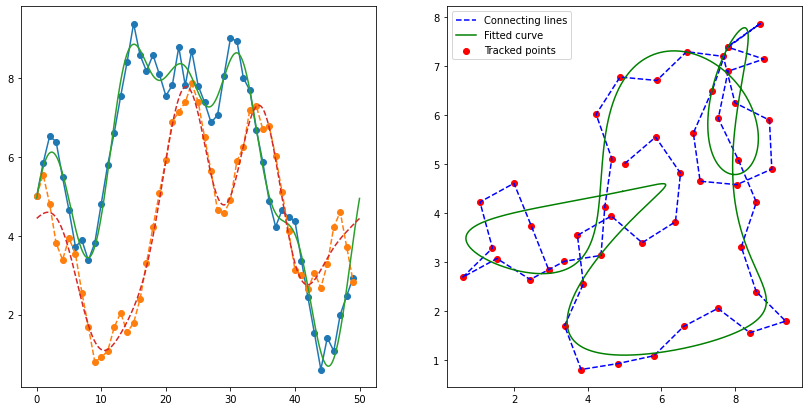

In [2]:
model = linear_model_np.LinearModel()
xy = model.genData(50)

N = np.arange(xy.shape[1])

basis_f = [lambda t: np.ones(t.shape),
           lambda t: np.cos(2.0 * np.pi * t / 50.0),
           lambda t: np.sin(2.0 * np.pi * t / 50.0),
           lambda t: np.cos(4.0 * np.pi * t / 50.0),
           lambda t: np.sin(4.0 * np.pi * t / 50.0),
           lambda t: np.cos(6.0 * np.pi * t / 50.0),
           lambda t: np.sin(6.0 * np.pi * t / 50.0),
           lambda t: np.cos(8.0 * np.pi * t / 50.0),
           lambda t: np.sin(8.0 * np.pi * t / 50.0),
           lambda t: np.cos(10.0 * np.pi * t / 50.0),
           lambda t: np.sin(10.0 * np.pi * t / 50.0),
           lambda t: np.cos(12.0 * np.pi * t / 50.0),
           lambda t: np.sin(12.0 * np.pi * t / 50.0)]

Psi = np.array([b(N) for b in basis_f]).T
Tmp = linalg.solve(Psi.T @ Psi, Psi.T)
cx = Tmp @ xy[0,:]
cy = Tmp @ xy[1,:]

t = np.arange(0,50,0.01)
PsiT = np.array([b(t) for b in basis_f]).T

print("cx = [", end="")
for i in range(len(cx)):
    print(f"{cx[i]:.4f}", end="")
    if i == len(cx)-1:
        print("]")
    else:
        print(",", end="")

print("cy = [", end="")
for i in range(len(cy)):
    print(f"{cy[i]:.4f}", end="")
    if i == len(cy)-1:
        print("]")
    else:
        print(",", end="")

print(xy[:,-1])        
        
fx = PsiT @ cx
fy = PsiT @ cy

f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
ax1.plot(N, xy[0,:],"o-", N, xy[1,:],"o--",
         t, fx, "-", t, fy, "--")


ax2.plot(xy[0,:], xy[1,:], label="Connecting lines", color="b", linestyle="--")
ax2.plot(fx, fy, label="Fitted curve", color="g", linestyle="-")
ax2.scatter(xy[0,:], xy[1,:], label="Tracked points", color="r")
_ = plt.legend()

fxy = np.stack((fx,fy))
np.savetxt('clqt_xy.txt',xy.T)
np.savetxt('clqt_fxy.txt',fxy.T)

Plot the curve from the CLQT model (NumPy version)

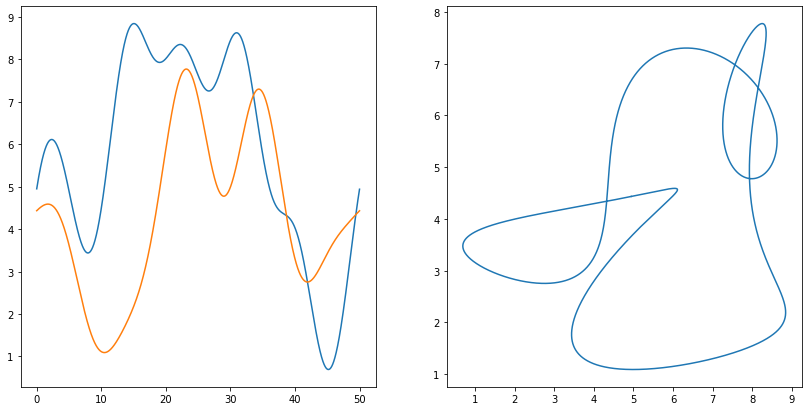

In [3]:
clqt, x0 = model.getCLQT()

f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
rxy = np.array([clqt.r(_t) for _t in t])
ax1.plot(t,rxy[:,0], t,rxy[:,1])
#ax1.plot(N, xy[0,:],"o-", N, xy[1,:],"o--")
ax2.plot(rxy[:,0], rxy[:,1])
#ax2.plot(xy[0,:], xy[1,:],'-')

Apply control and show the result

In [4]:
steps = 5000

Kx_list, d_list, S_list, v_list = clqt.seqBackwardPass(steps)
u_list, x_list = clqt.seqForwardPass(x0, Kx_list, d_list)

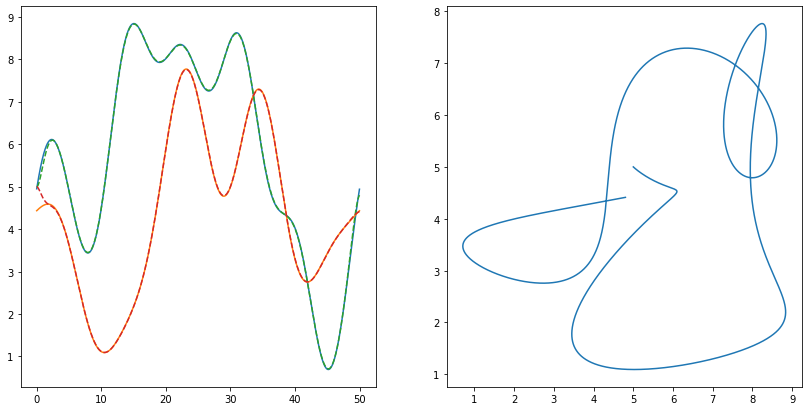

In [5]:
xs1 = np.array(x_list)
us1 = np.array(u_list)
tt1 = np.arange(0, steps+1) * clqt.T / steps

np.savetxt('clqt_xs.txt',xs1)
np.savetxt('clqt_us.txt',us1)
np.savetxt('clqt_ts.txt',tt1)


f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
ax1.plot(t, rxy[:,0], t, rxy[:,1])
ax1.plot(tt1, xs1[:,0], '--', tt1, xs1[:,1], '--')
ax2.plot(xs1[:,0], xs1[:,1])

TensorFlow version of the curve

In [6]:
import tensorflow as tf
import parallel_control.linear_model_tf as linear_model_tf
import parallel_control.clqt_tf as clqt_tf
import parallel_control.parareal_clqt_tf as para_tf


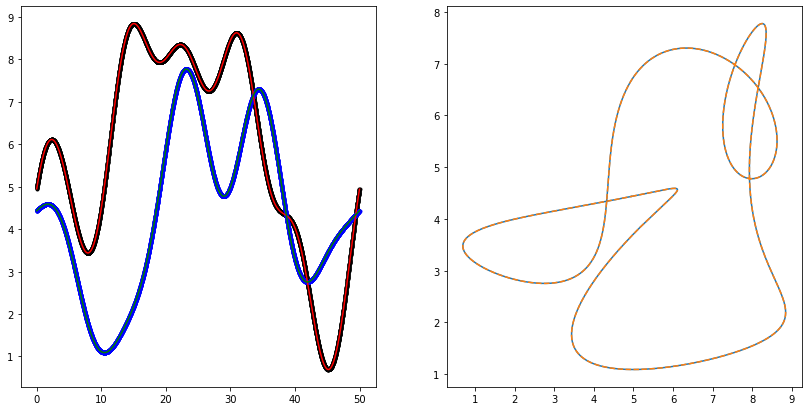

In [7]:
x0_tf, T, XT, HT, rT, F_f, L_f, X_f, U_f, c_f, H_f, r_f = linear_model_tf.get_clqt()

dt = 0.01
t_tf = tf.range(0, T, dt)
tmp = tf.vectorized_map(r_f, t_tf)

clqt, x0 = model.getCLQT()

f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
ax1.plot(t_tf, tmp[:,0], 'k.--', t_tf, tmp[:,1], 'b.--')
ax1.plot(t, rxy[:,0], 'r-', t, rxy[:,1], 'g-')
ax2.plot(rxy[:,0], rxy[:,1])
ax2.plot(tmp[:,0], tmp[:,1], '--')


Apply control (in TF) and show the result

In [8]:
dt, t0, ST, vT = clqt_tf.clqt_seq_backwardpass_defaults(steps, XT, HT, rT, T)
Ss2, vs2, Kxs2, ds2 = clqt_tf.clqt_seq_backwardpass(steps, dt, t0, ST, vT, F_f, L_f, X_f, U_f, c_f, H_f, r_f)
xs2, us2 = clqt_tf.clqt_seq_forwardpass(x0_tf, Kxs2, ds2, dt, t0, F_f, L_f, c_f)

print(xs2.shape)

(5001, 4)


tf.Tensor(5.329070518200751e-15, shape=(), dtype=float64)


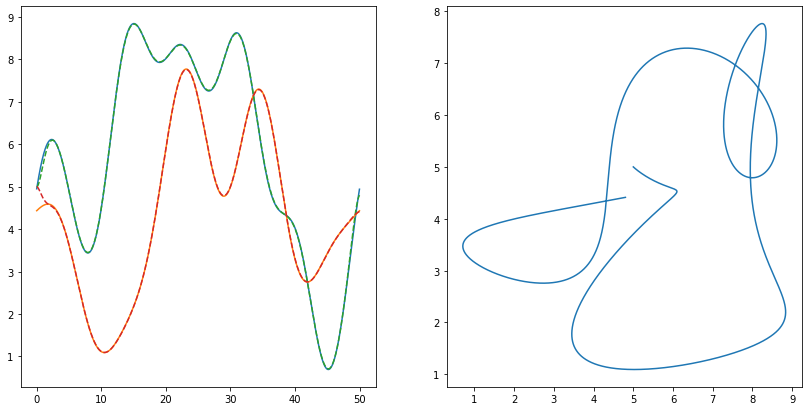

In [9]:
tt2 = np.arange(0, steps+1) * clqt.T / steps

f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
ax1.plot(t, rxy[:,0], t, rxy[:,1])
ax1.plot(tt2, xs2[:,0], '--', tt2, xs2[:,1], '--')
ax2.plot(xs2[:,0], xs2[:,1])

err = tf.reduce_max(tf.math.abs(xs1 - xs2))
print(err)

Using parallel methods

In [10]:
blocks = 500
steps = 10
dt, t0, ST, vT = clqt_tf.par_backwardpass_defaults(blocks, steps, XT, HT, rT, T)
Ss3, vs3, Kxs3, ds3 = clqt_tf.clqt_par_backwardpass(blocks, steps, dt, t0, ST, vT, F_f, L_f, X_f, U_f, c_f, H_f, r_f)
xs3, us3 = clqt_tf.clqt_par_forwardpass(blocks, steps, x0_tf, Kxs3, ds3, dt, t0, F_f, L_f, c_f)

print(xs3.shape)

(5001, 4)


In [11]:
dt, t0, ST, vT = clqt_tf.par_backwardpass_defaults(blocks, steps, XT, HT, rT, T)
Ss4, vs4, Kxs4, ds4 = clqt_tf.clqt_par_backwardpass(blocks, steps, dt, t0, ST, vT, F_f, L_f, X_f, U_f, c_f, H_f, r_f)
xs4, us4 = clqt_tf.clqt_par_fwdbwdpass(blocks, steps, x0_tf, Ss4, vs4, Kxs4, ds4, dt, t0, F_f, L_f, X_f, U_f, c_f, H_f, r_f)

print(xs4.shape)

(5001, 4)


In [12]:
niter = 5
Ss5, vs5, Kxs5, ds5 = para_tf.pclqt_backwardpass(blocks, steps, niter, XT, HT, rT, T, F_f, L_f, X_f, U_f, c_f, H_f, r_f)

In [13]:
niter = 5
Ss6, vs6, Kxs6, ds6 = para_tf.pclqt_backwardpass(blocks, steps, niter, XT, HT, rT, T, F_f, L_f, X_f, U_f, c_f, H_f, r_f)
xs6, us6 = para_tf.pclqt_forwardpass(blocks, steps, niter, x0_tf, T, Kxs6, ds6, F_f, L_f, c_f)

print(xs6.shape)

(5001, 4)


In [14]:
err = tf.reduce_max(tf.math.abs(xs1 - xs3))
print(err)
err = tf.reduce_max(tf.math.abs(xs1 - xs4))
print(err)
err = tf.reduce_max(tf.math.abs(xs1 - xs6))
print(err)

tf.Tensor(1.3767305484524428e-07, shape=(), dtype=float64)
tf.Tensor(0.0091698326205375, shape=(), dtype=float64)
tf.Tensor(6.686040610048849e-11, shape=(), dtype=float64)


# Run the speed tests

In [15]:
blocks = 100
steps = 50

model = clinspeed.clqr_get_tracking_model()
for i in [1,2,3]:
    elapsed, err = clinspeed.clqt_seq_bw_fw_speedtest(model, i*blocks, steps)
    print(f"elapsed = {elapsed}, err = {err}")


Running clqt_seq_bw_fw_speedtest on device /CPU:0
blocks=100, steps=50 took 1328.672171 ms.
elapsed = 1.328672170639038, err = 0.0
Running clqt_seq_bw_fw_speedtest on device /CPU:0
blocks=200, steps=50 took 2811.043811 ms.
elapsed = 2.8110438108444216, err = 0.0
Running clqt_seq_bw_fw_speedtest on device /CPU:0
blocks=300, steps=50 took 3979.525614 ms.
elapsed = 3.97952561378479, err = 0.0


In [16]:
model = clinspeed.clqr_get_tracking_model()
for i in [1,2,3]:
    elapsed, err = clinspeed.clqt_par_bw_fw_speedtest(model, i*blocks, steps)
    print(f"elapsed = {elapsed}, err = {err}")


Running clqt_par_bw_fw_speedtest on device /CPU:0
blocks=100, steps=50 took 60.151005 ms.
elapsed = 0.06015100479125977, err = 6.227106397194149e-08
Running clqt_par_bw_fw_speedtest on device /CPU:0
blocks=200, steps=50 took 85.605502 ms.
elapsed = 0.08560550212860107, err = 6.9111990574910465e-09
Running clqt_par_bw_fw_speedtest on device /CPU:0
blocks=300, steps=50 took 126.332307 ms.
elapsed = 0.12633230686187744, err = 1.6032088989703652e-09
